<h1>Potato disease Analysis</h1>
<p>The Potato Disease Analysis project aims to develop a deep learning model capable of identifying diseases in potato plants based on images. The CNN model is constructed using TensorFlow and Keras, and training is performed on the provided dataset.</p>

In [181]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [230]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle  = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [22]:
len(dataset)

# total 68 batches
# Every batch has 32 images
# Every image size is 256 256
# 3 rgb channels

68

In [24]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 2 1 1 1 0 0 1 1 1 1 0 1 0 1 1]


### Visualization

(256, 256, 3)


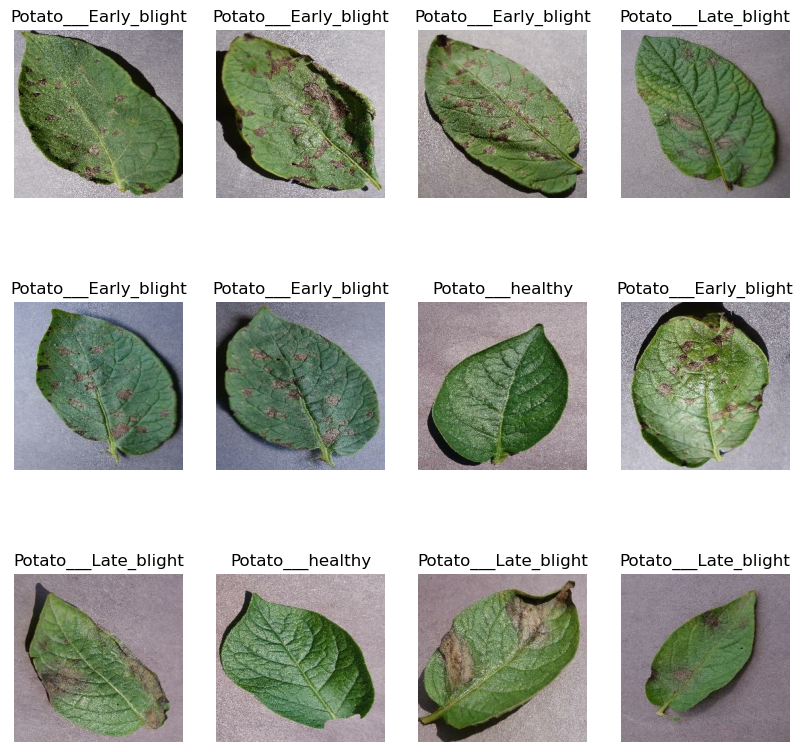

In [103]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1): 
    print(image_batch[0].shape)    
    
    for i in range(12):      
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    


### train, test slpit

In [111]:
train_size = 0.8
test_size = 0.1
validation_size = 0.1
print(len(dataset) * train_size)
print(len(dataset) * test_size)
print(len(dataset) * validation_size)

54.400000000000006
6.800000000000001
6.800000000000001


In [112]:
train_ds = dataset.take(54)

rem_ds = dataset.skip(54)
val_ds = rem_ds.take(6)
test_ds = rem_ds.skip(6)


In [115]:
len(test_ds)

8

In [116]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_size = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [117]:
train_ds , val_size, test_size = get_dataset_partitions_tf(dataset)

##### cache()
  it will read the image from the disk and then when the next itration need this image, it will keep the
  image in the memory. This improve the performance of the pipeline.

##### prefetch()
  If have GPU and CPU and GPU is busy in training, prefetch will load the next set of batch from disk.
  That's how it will improve the performance.

In [122]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Preprocessing

In [124]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/ 255)
])

##### data augmentation(rotation and scaling)

In [125]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model

In [231]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation= 'softmax')
])
model.build(input_shape= input_shape)

In [232]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [233]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics = ['accuracy']
)

In [234]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE, 
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/10
54/54 [==============================] - 357s 7s/step - loss: 0.9129 - accuracy: 0.4763 - val_loss: 0.8785 - val_accuracy: 0.5104
Epoch 2/10
54/54 [==============================] - 389s 7s/step - loss: 0.6592 - accuracy: 0.6834 - val_loss: 0.5305 - val_accuracy: 0.7760
Epoch 3/10
54/54 [==============================] - 414s 8s/step - loss: 0.4004 - accuracy: 0.8391 - val_loss: 0.4182 - val_accuracy: 0.8438
Epoch 4/10
54/54 [==============================] - 307s 6s/step - loss: 0.3096 - accuracy: 0.8762 - val_loss: 0.2855 - val_accuracy: 0.8854
Epoch 5/10
54/54 [==============================] - 288s 5s/step - loss: 0.2807 - accuracy: 0.8883 - val_loss: 0.1360 - val_accuracy: 0.9479
Epoch 6/10
54/54 [==============================] - 284s 5s/step - loss: 0.2199 - accuracy: 0.9190 - val_loss: 0.2363 - val_accuracy: 0.9062
Epoch 7/10
54/54 [==============================] - 278s 5s/step - loss: 0.1952 - accuracy: 0.9242 - val_loss: 0.2254 - val_accuracy: 0.9062
Epoch 8/10
54

In [235]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 14s 2s/step - loss: 0.0611 - accuracy: 0.9784


[0.06113308295607567, 0.9784482717514038]

In [236]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [237]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [238]:
len(history.history['accuracy'])

10

### visualization

In [239]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

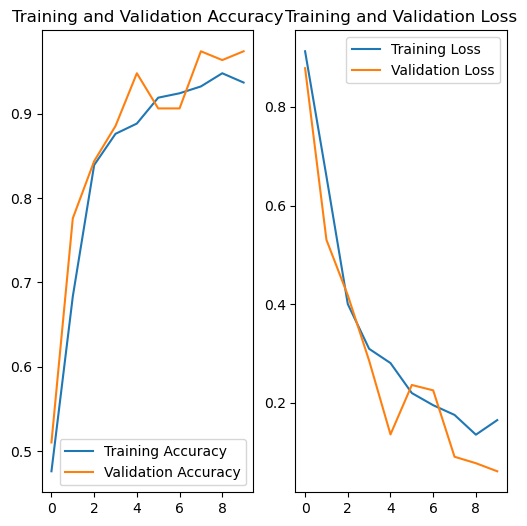

In [240]:
plt.figure(figsize = (6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")

first image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 3s 3s/step
predicted label:  Potato___Early_blight
0


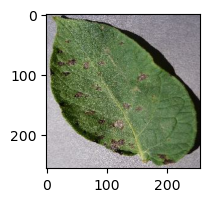

In [266]:
plt.figure(figsize= (2, 2))
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    
    batch_prediction = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])
    
    print(round(100 * np.argmax(batch_prediction[0]), 2))

In [275]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 102ms/step


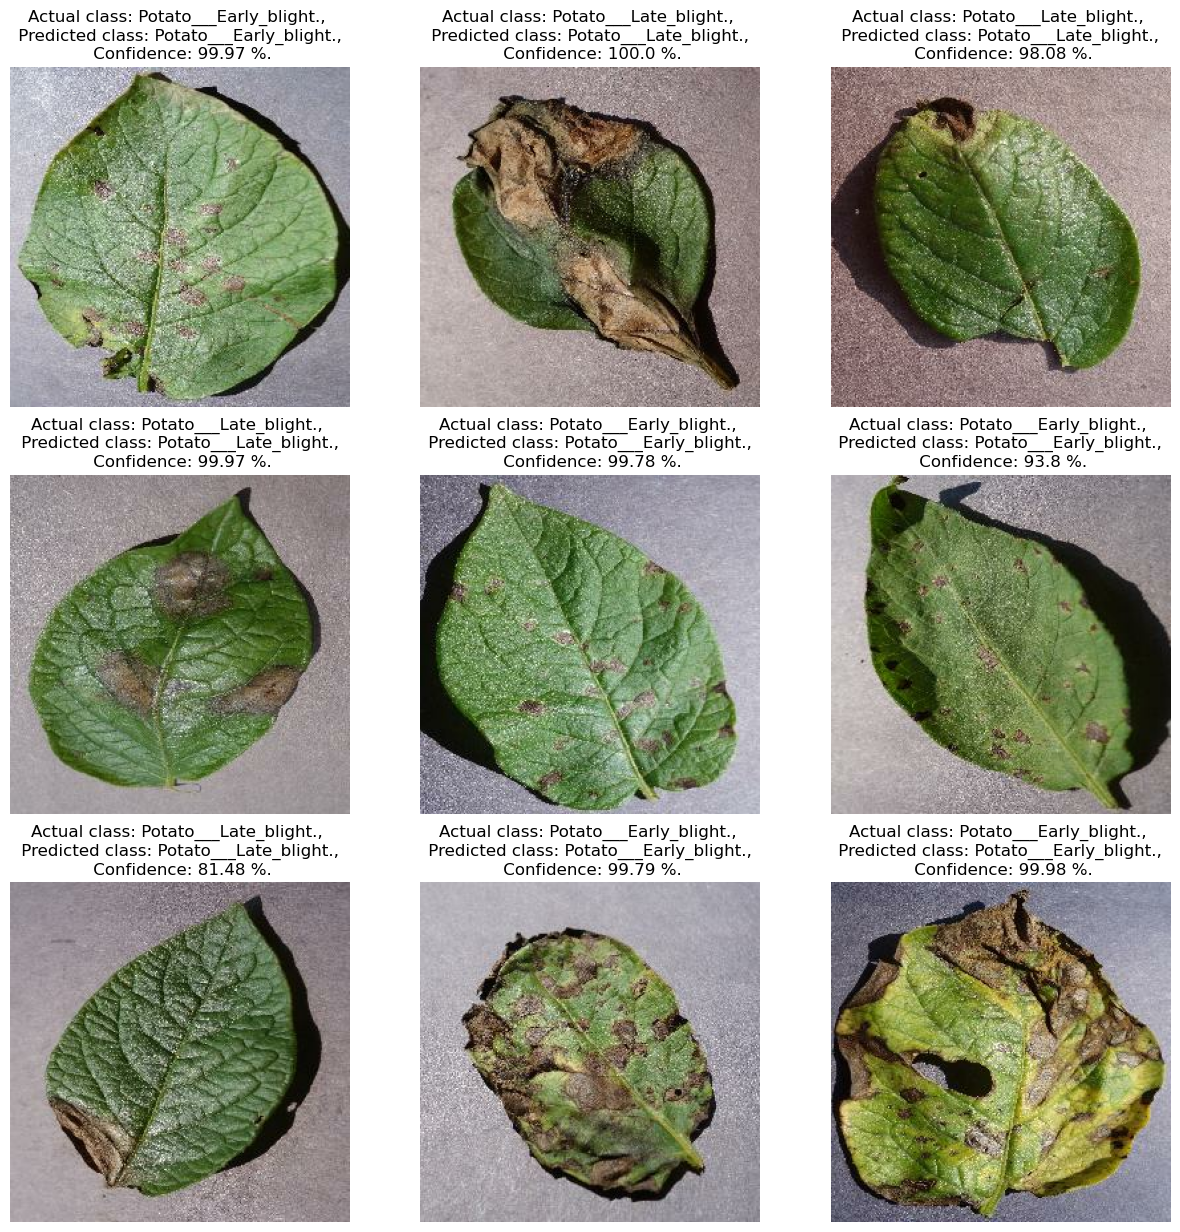

In [276]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predict_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual class: {actual_class}., \n Predicted class: {predict_class}., \n Confidence: {confidence} %.")
        
        plt.axis("off")

In [278]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+ 1 
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [279]:
tf.__version__

'2.10.0'